<h1>Spacial density of Na and K in various traps</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from typing import Union

from quantum_statistics import (
    ParticleProps, 
    BEC, 
    FermiGas, 
    harmonic_trap,
    box_trap,
    box_2d_harmonic_1d_trap,
    analyze_bec,
    analyze_fermi_gas,
    plot_condens_frac,
)

<h3>Test with perfect isotropic harmonic trap</h3>

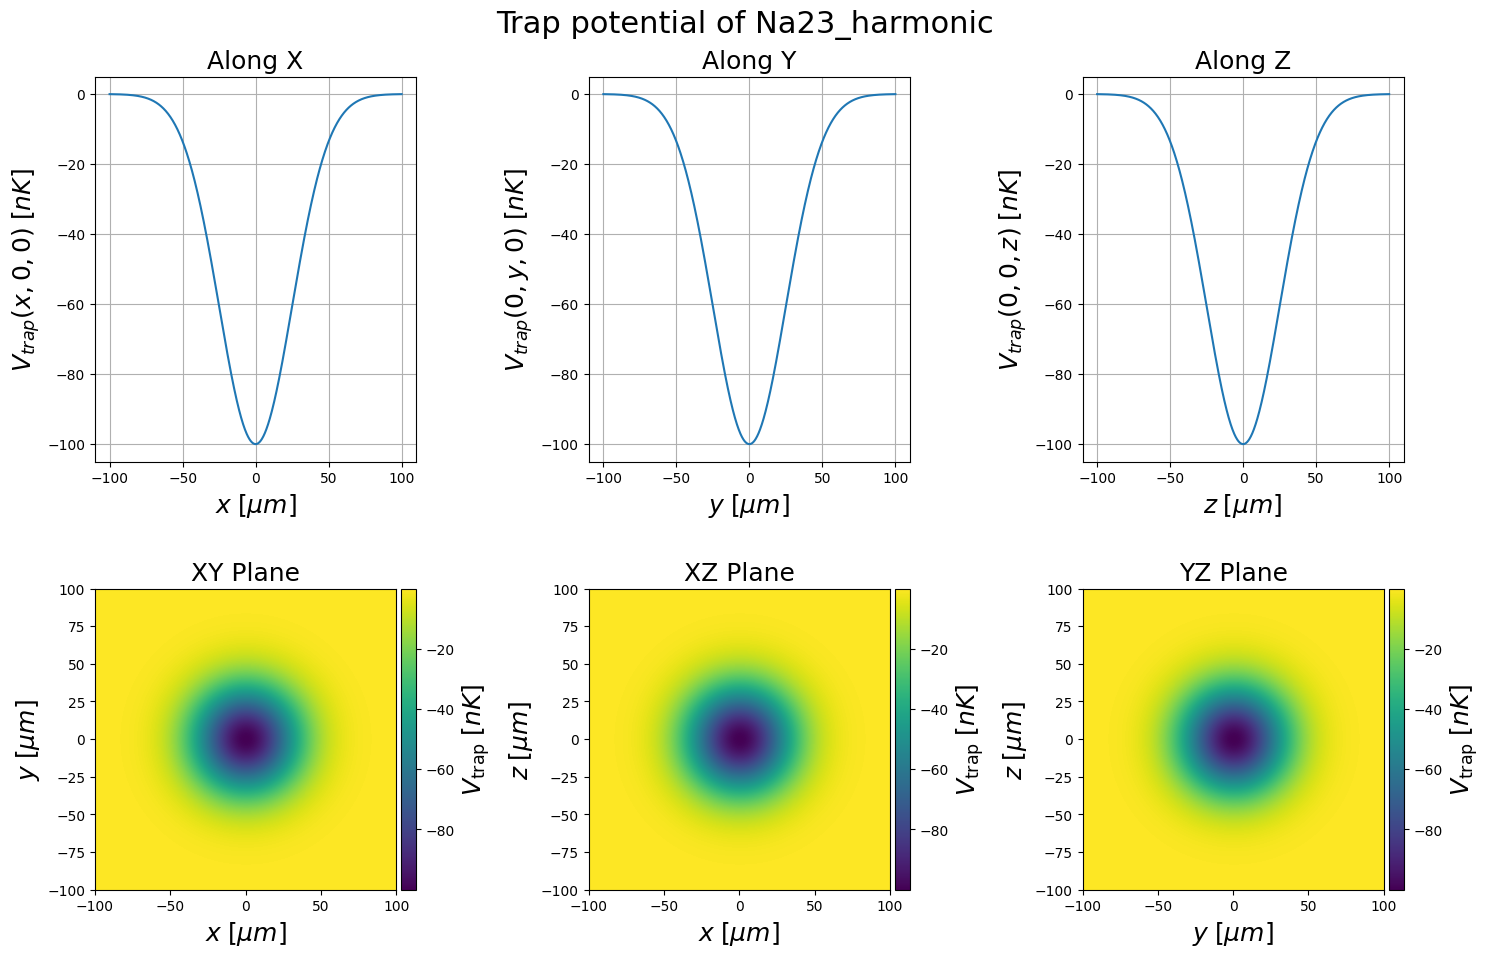

In [2]:
na23_harmonic = ParticleProps(
    name="Na23_harmonic",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=0*u.nK, # We will later loop over a range of temperatures, so this is just a placeholder
    a_s=2.75*u.nm,
    domain=(-100, 100) * u.um,
    V_trap=harmonic_trap,
    trap_depth=100, # kwarg for V_trap
    waist=50,       # kwarg for V_trap
    inhomogenity=0, # kwarg for V_trap
)

k40_harmonic = ParticleProps(
    name="K40_harmonic",
    species="fermion",
    m=39.963999*u.u,
    N_particles=200000,
    T=0*u.nK,
    domain=(-100, 100) * u.um,
    V_trap=harmonic_trap,
    trap_depth=1700, # kwarg for V_trap
    waist=50,          # kwarg for V_trap
    inhomogenity=0,    # kwarg for V_trap
)

na23_harmonic.plot_V_trap()

In [3]:
k40_harmonic.T = 10*u.nK
fg = FermiGas(k40_harmonic)
fg.eval_density(mu_change_rate=10, print_convergence_info_at_this_iteration=5)

  0%|          | 1/1000 [00:05<1:31:37,  5.50s/it]

Iteration 0:
N:  113.50892916386111
mu:  -1114.840595415659 nK
delta_mu:  9.994324553541901
new_mu_direction:  0.9994324553541807 nK
mu_change_rate:  10




  1%|          | 6/1000 [00:27<1:08:33,  4.14s/it]

Iteration 5:
N:  1520.5899382370694
mu:  -1065.2360391439413 nK
delta_mu:  9.923970503088185
new_mu_direction:  0.9923970503088146 nK
mu_change_rate:  10




  1%|          | 11/1000 [00:46<1:04:07,  3.89s/it]

Iteration 10:
N:  787.3808490839227
mu:  -967.2464444400483 nK
delta_mu:  19.921261915091577
new_mu_direction:  0.9960630957545804 nK
mu_change_rate:  20




  2%|▏         | 16/1000 [01:05<1:05:19,  3.98s/it]

Iteration 15:
N:  371.4952201847765
mu:  -795.1672170900171 nK
delta_mu:  39.925700955963066
new_mu_direction:  0.9981425238990762 nK
mu_change_rate:  40




  2%|▏         | 21/1000 [01:27<1:09:57,  4.29s/it]

Iteration 20:
N:  6605.911577630688
mu:  -401.8896365282387 nK
delta_mu:  77.35763536894774
new_mu_direction:  0.9669704421118465 nK
mu_change_rate:  80




  3%|▎         | 26/1000 [01:47<1:05:21,  4.03s/it]

Iteration 25:
N:  0.0
mu:  199.57629883835526 nK
delta_mu:  160.0
new_mu_direction:  1.0 nK
mu_change_rate:  160




  3%|▎         | 29/1000 [02:02<1:08:26,  4.23s/it]


KeyboardInterrupt: 

AttributeError: 'FermiGas' object has no attribute 'n_ex_array'

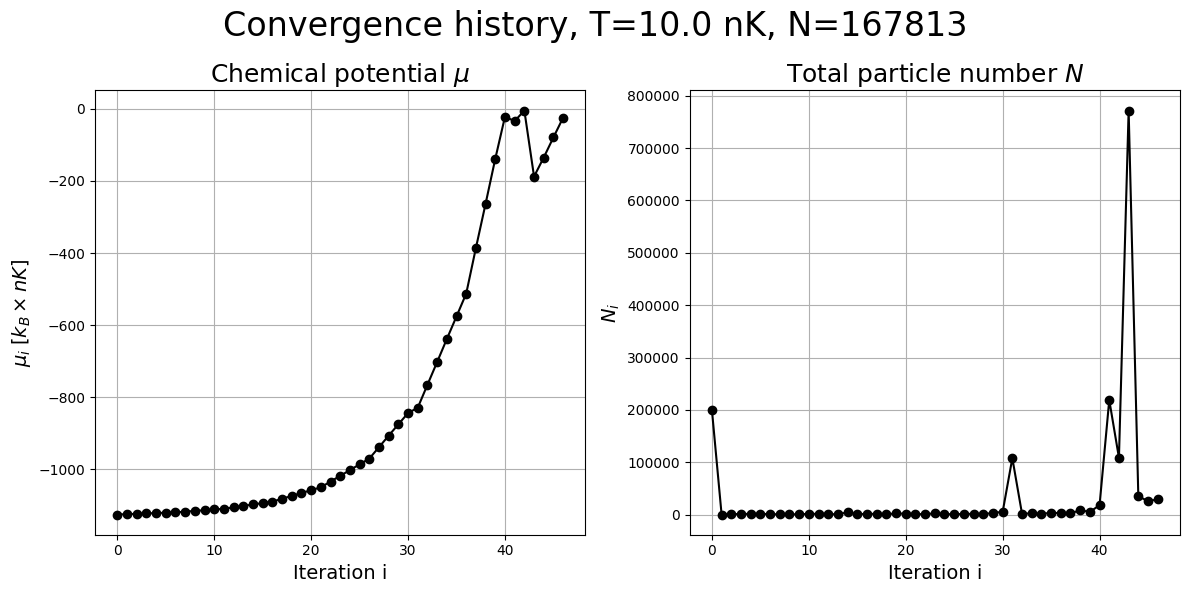

In [ ]:
fg.plot_all()

In [ ]:
Ts = np.linspace(0, 60, 3) * u.nK
becs = analyze_bec(Ts, na23_harmonic, mu_change_rate=1)
fgs = analyze_fermi_gas(Ts, k40_harmonic, )

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 18/1000 [00:00<00:39, 24.65it/s]


Convergence reached after 18 iterations.


  2%|▏         | 18/1000 [01:40<1:31:14,  5.57s/it]


Convergence reached after 18 iterations.


  3%|▎         | 33/1000 [03:01<1:28:32,  5.49s/it]


Convergence reached after 33 iterations.


  7%|▋         | 74/1000 [00:01<00:21, 43.29it/s]


Convergence reached after 74 iterations.


 15%|█▍        | 149/1000 [12:27<1:11:10,  5.02s/it]


KeyboardInterrupt: 

<h3>Inhomogeneous box trap</h3>

In [ ]:
na23_inhomog_box = ParticleProps(
    name="Na23_inhomog_box",
    species="boson",
    m=22.989768*u.u,
    N_particles=200000,
    T=0*u.nK,
    domain=(-100, 100) * u.um,
    V_trap=box_trap,
    trap_depth=500,    # kwarg for V_trap
    box_width=100,     # kwarg for V_trap
    inhomogenity=0.01, # kwarg for V_trap
)

k40_inhomog_box = ParticleProps(
    name="K40_inhomog_box",
    species="fermion",
    m=39.963999*u.u,
    N_particles=200000,
    T=0*u.nK,
    domain=(-100, 100) * u.um,
    V_trap=box_trap,
    trap_depth=1500, # kwarg for V_trap
    box_width=100,     # kwarg for V_trap
    inhomogenity=0.01, # kwarg for V_trap
)

In [ ]:
Ts = np.linspace(0, 46, 10) * u.nK
becs = analyze_bec(Ts, na23_harmonic)

  0%|          | 5/1000 [00:00<00:46, 21.61it/s]


Convergence reached after 5 iterations.


  0%|          | 2/1000 [00:12<1:46:18,  6.39s/it]


Convergence reached after 2 iterations.


  0%|          | 2/1000 [00:12<1:41:04,  6.08s/it]


Convergence reached after 2 iterations.


  0%|          | 3/1000 [00:16<1:30:15,  5.43s/it]


Convergence reached after 3 iterations.


  0%|          | 3/1000 [00:15<1:27:12,  5.25s/it]


Convergence reached after 3 iterations.


  0%|          | 4/1000 [00:21<1:27:21,  5.26s/it]


Convergence reached after 4 iterations.


  0%|          | 4/1000 [00:21<1:30:24,  5.45s/it]


Convergence reached after 4 iterations.


  0%|          | 4/1000 [00:32<2:16:43,  8.24s/it]


Convergence reached after 4 iterations.


  0%|          | 4/1000 [00:28<1:58:21,  7.13s/it]


Convergence reached after 4 iterations.


  0%|          | 4/1000 [00:20<1:26:56,  5.24s/it]

Convergence reached after 4 iterations.
